In [43]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision. transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [44]:
project_name = 'fashion-feedforward-minimal'

In [45]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_dataset = FashionMNIST(root='data/', train=False, transform=ToTensor())

In [46]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [47]:
batch_size = 128

In [48]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
# train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
# in the above line I used pin_memory=True to to improve data transfer speed from CPU to GPU.
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


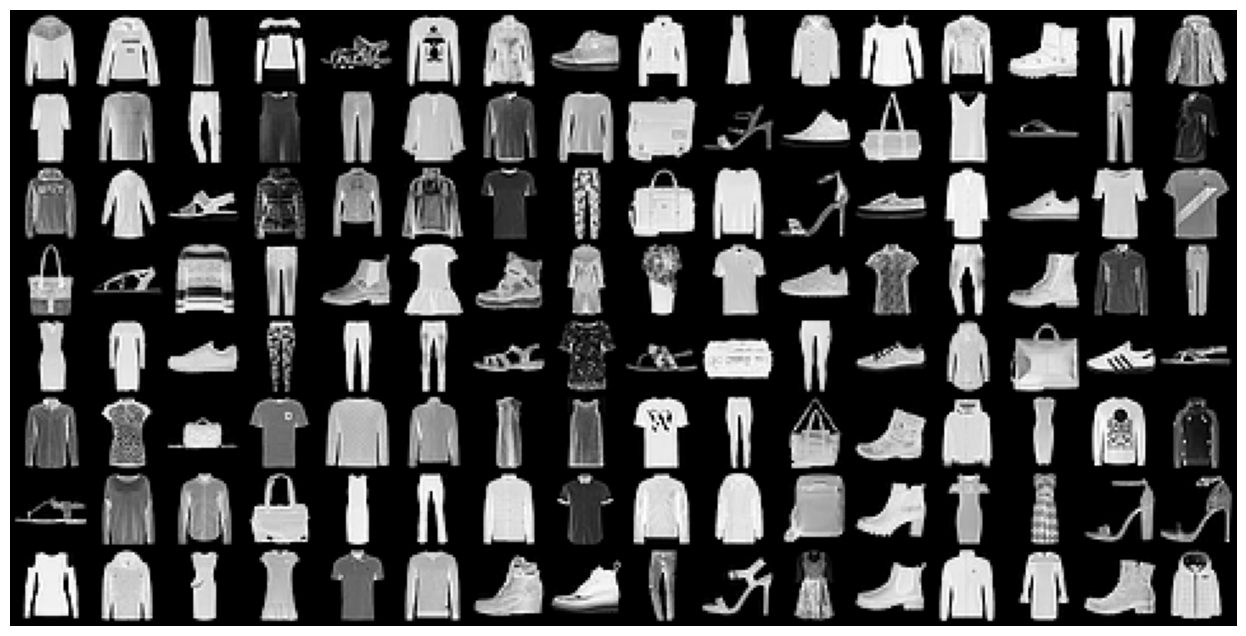

In [49]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [50]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [51]:
class MnistModel(nn.Module):
    #Feed Forward neural network with 2 hidden layer
    def __init__(self, in_size, out_size):
        super().__init__()
        #hidden layer 1
        self.linear1 = nn.Linear(in_size, 16)
        #hidden layer 2
        self.linear2 = nn.Linear(16, 32)
        #output layer
        self.linear3 = nn.Linear(32, out_size)

    def forward(self, xb):
        #Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        #Get intermidiate outputs using hidden layer 1
        out = self.linear1(out)
        #Apply activation function
        out = F.relu(out)
        #Get Get intermidiate outputs using hidden layer 2
        out = self.linear2(out)
        #Apply activation function
        out = F.relu(out)
        #Get predictions using output layer
        out = self.linear3 (out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  #generating predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  #generate predictions
        loss = F.cross_entropy(out, labels)  #calculate loss
        acc = accuracy(out, labels)    #calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  #Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()   # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [52]:
torch.cuda.is_available()

False

In [53]:
def get_default_device():
    #pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [54]:
device = get_default_device()
device

device(type='cpu')

In [55]:
def to_device(data, device):
    #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [56]:
class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        #Yeild a betach of data after moving it to device
        for b in self.dl:
            yield to_device(b, self.device)


    def __len__(self):
        #number of Batches
        return len(self.dl)

In [57]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [58]:
def evaluate(model, val_loader):
    #Evaluates the model's performance on the validation set
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    # for recording epoch-wise results
        #training the model using gradient descent
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):

        # training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation Phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [59]:
input_size = 784
num_classes = 10

In [60]:
model = MnistModel(input_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [61]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3103950023651123, 'val_acc': 0.06484375149011612}]

In [ ]:
history += fit(5, 0.5, model, train_loader, val_loader)

In [ ]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4065, val_acc: 0.8521
Epoch [1], val_loss: 0.4064, val_acc: 0.8533
Epoch [2], val_loss: 0.3955, val_acc: 0.8560
Epoch [3], val_loss: 0.3986, val_acc: 0.8532
Epoch [4], val_loss: 0.3929, val_acc: 0.8572


In [ ]:
history += fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3870, val_acc: 0.8598
Epoch [1], val_loss: 0.3863, val_acc: 0.8595
Epoch [2], val_loss: 0.3863, val_acc: 0.8597
Epoch [3], val_loss: 0.3861, val_acc: 0.8603
Epoch [4], val_loss: 0.3856, val_acc: 0.8591


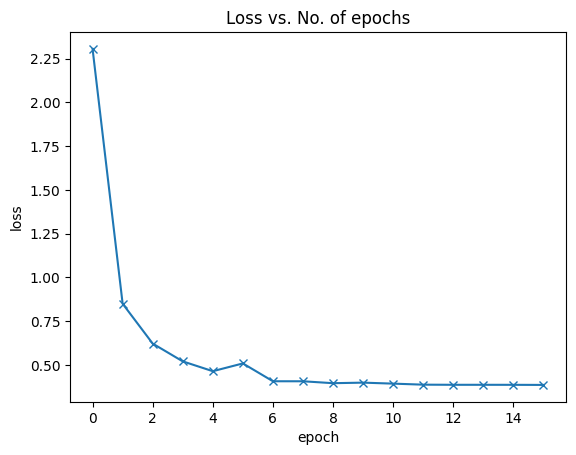

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

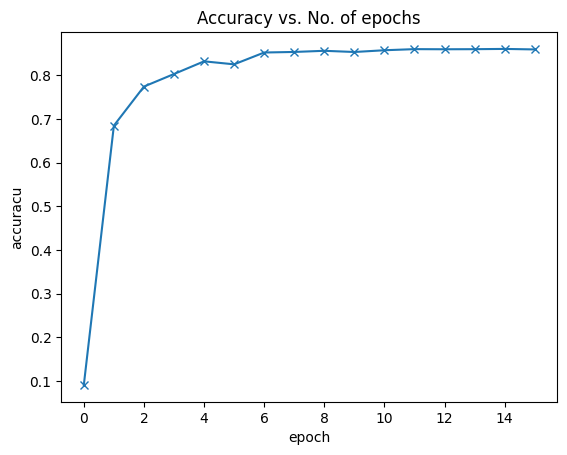

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: Ankle boot , Predicted: Ankle boot


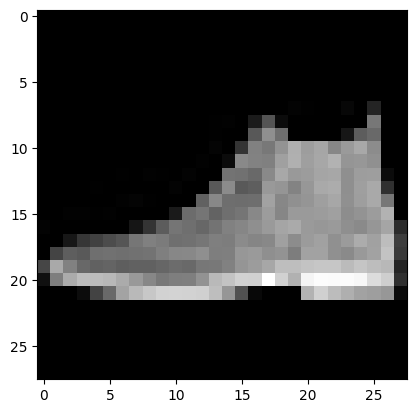

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Label: Ankle boot , Predicted: Ankle boot


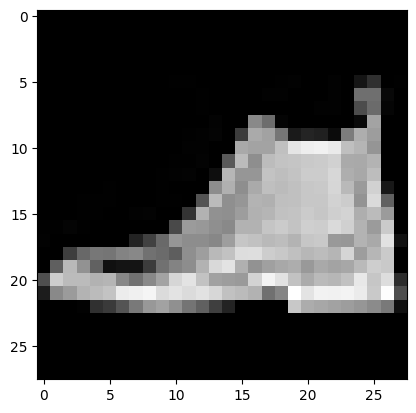

In [ ]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Label: Shirt , Predicted: Shirt


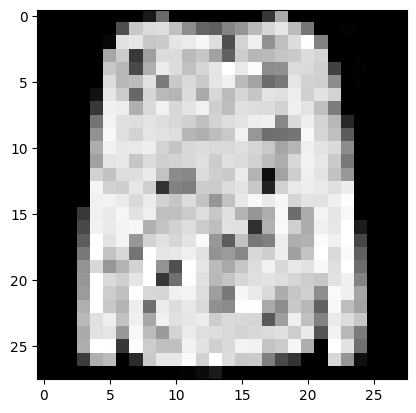

In [ ]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

In [ ]:
result = evaluate(model, test_loader)
result

c:\Users\jaisw\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'val_loss': 0.4090942442417145, 'val_acc': 0.8525390625}

In [ ]:
torch.save(model.state_dict(), 'fashion-mnist-feedforward.pth')